# Comprehensive Tutorial on PyTorch Lightning

## Introduction to PyTorch Lightning

PyTorch Lightning is a massively popular wrapper for PyTorch that makes it easy to develop and train deep learning models. It eliminates the boilerplate code for training loops and complex setups which is cumbersome for many developers and allows you to focus on the core model and experiment logic.

Key features:
- Simplifies the codebase through minimal boilerplate code.
- Easy multi-GPU and distributed training for scalability.
- Seamless integration with PyTorch.
- Encourages organized and modular code.
- Simplifies complex setups like mixed precision and distributed training.
- Built-in features for checkpoints, logs, and experiment tracking.

We will see the benefits of these features as we go through real-world examples in this tutorial. Let's get started!

## Setting Up Your Environment

### Setup and installation

Before we dive into the code, let's set up our environment. We will start by creating a Conda environment:

```bash
$ conda create -n lightning python=3.9 -y
$ conda activate lightning
```

The next step is installing `lightning` and a few other necessary libraries:

```bash
$ pip install lightning torchmetrics
$ pip install ipykernel pandas
```

We will need `torchmetrics` for evaluating model performances while `ipykernel` lets us add our new Conda environment to Jupyter as a kernel:


```bash
$ ipython kernel install --user --name=lightning
```

`lightning` automatically installs classic PyTorch, so the following code must work:

In [1]:
import lightning as L
import torch

print("Lightning version:", L.__version__)
print("Torch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

Lightning version: 2.3.2
Torch version: 2.1.2+cu121
CUDA is available: True


It is recommended to run the code examples on a machine with a GPU. You can see installation options from [this page](https://pytorch.org/get-started/locally/) of PyTorch docs.

The tutorial includes a PyTorch refresher section but if you are completely new, here are some relevant resources:

- [Introduction to PyTorch Tutorial](https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch)
- [Introduction to Deep Learning In PyTorch](https://www.datacamp.com/courses/introduction-to-deep-learning-with-pytorch)
- [Intermediate Deep Learning With PyTorch](https://www.datacamp.com/courses/intermediate-deep-learning-with-pytorch)
- [Deep Learning For Images With PyTorch](https://www.datacamp.com/courses/deep-learning-for-images-with-pytorch)
- [Deep Learning in Python Skill Track](https://datacamp.com/tracks/deep-learning-in-python)


Otherwise, let's import some necessary modules:

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

These imports give us access to PyTorch Lightning's core functionality (`L`), PyTorch's neural network modules (`nn`), and various utility functions. 

It is also a good practice to set random seed for reproducibility:

In [10]:
L.seed_everything(1121218)

Seed set to 1121218


1121218

Let's also set a few hyperparameters that rarely change for the rest of the tutorial:

In [26]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

> Note on terminology: as of writing this, two different names exist for PyTorch Lightning Python package. In the past, it was named `pytorch_lightning` and imported as `pl`. After the company behind the framework got rebranded to Lightning AI, the package name was changed to `lightning`. Even though the old version still gets updates and downloads, it is recommended to use `lightning`. 

### Problem statement and downloading a dataset

We will see how to take advantage of PyTorch Lightning through a classic multi-class classification problem using the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). 

The dataset consists of 60 thousand 32x32 color images in 10 classes, with 6000 images per class. 

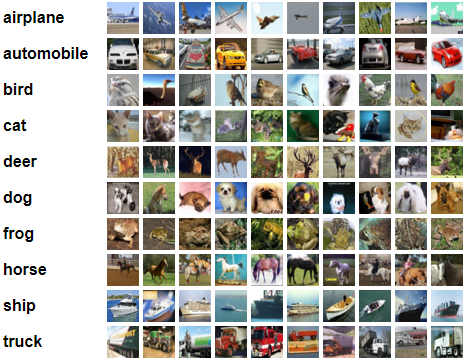

You can download the data as a `tar.gz` file but that involves too many extraction and processing steps. Instead, we can use the `datasets.CIFAR10` function from `torchvision`:

```python
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

val_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
```

Here is the breakdown of the code above:
- `root`: Specifies the location of to download the dataset.
- `train`: Specifies whether to download the train or test set
- `download`: Whether to download the dataset from source. If it already exists, it is verified against the source.

The `transform` argument expects a transformation pipeline defined using the `transforms.Compose` class. Here are `transform_train` and `transform_test` pipelines used above:

In [22]:
# Data augmentation and normalization for training
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ], 
)

transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [29]:
## HIDE THIS ##
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


People familiar with PyTorch will know that these pipelines perform data augmentation in which dataset size is artificially increased through random transformations. The training pipeline is performing these operations on images randomly:
- Cropping (requires image size to be specified, 32x32 in this case)
- Horizontal flipping
- Converting to a tensor data type required for PyTorch
- Normalization of each color channel of images

Data augmentation doesn't create new images but duplicates the existing ones from different "angles" or "lenses" helping any model to learn from more information. 

Once the dataset is downloaded, you will have a `data` directory with the following structure:

```
./data/cifar-10-batches-py/
├── batches.meta
├── data_batch_1
├── data_batch_2
├── data_batch_3
├── data_batch_4
├── data_batch_5
├── readme.html
└── test_batch
```

The `data_batch_*` and `test_batch` are Python pickle files containing the images and labels. Each batch contains a dictionary with the following elements:
- `data`: A 10000x3072 numpy array of `uint8`s. Each row is a 32x32 color image with 3 channels (RGB).
- `labels`: A list of 10000 numbers in the range 0-9, representing the class of each image.

The `datasets.CIFAR10` function takes care of unpickling these files and presenting them in a format compatible to PyTorch `DataLoaders`:

In [30]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

`DataLoader` classes are essential utilities for data preparation and model training. They:
- Handle data loading, preprocessing and batching simultaneously
- Supports multi-threading to maximize CPU utilization (`num_workers`)
- Minimizes training bottlenecks
- Shuffles the data after every epoch (`shuffle`)
- Highly efficient for large datasets

Whether you use classic Torch or the new Lightning, data loading and preparation stays more or less the same as both use PyTorch `Dataset` objects or `DataLoader`s. 

Now, we will train a CNN model using both classic Torch and Lightning and compare the differences. 

## PyTorch Workflow Revisited

FILL IN LATER

### Defining model architecture

After creating data loaders, the first step is defining the model architecture:

In [34]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

By sub-classing the `nn.Module` (neural networks) module of PyTorch, we can create complex and flexible architectures. Above, we are creating three convolution layers followed by max pooling and then, two linear layers. The `forward` method defines the ordering of these layers and adds activation functions. 

You will see that the model architecture syntax stays the same for Lightning except for one detail (we will see it later). Every subsequent step changes as Lightning introduces better syntax that reduces boilerplate code.

### Writing training loop and validation loops

The next part is writing the dreaded training and validation loop which requires you to memorize the order of the following steps:
- Initializing the model, loss function and optimizers
- Device management (CPU vs. GPU)
- Training steps: forward pass, loss computation, backpropagation, and optimization
- Validation steps: computing accuracy and loss
- Tensorboard logging
- Model saving

The result is a code snippet so large that requires a few dozen practice sessions to completely memorize (I pasted the code in [this GitHub gist](https://gist.github.com/BexTuychiev/e96c81ec851567ba4306aea38ed4f3ac) to save space; below is the top few lines):

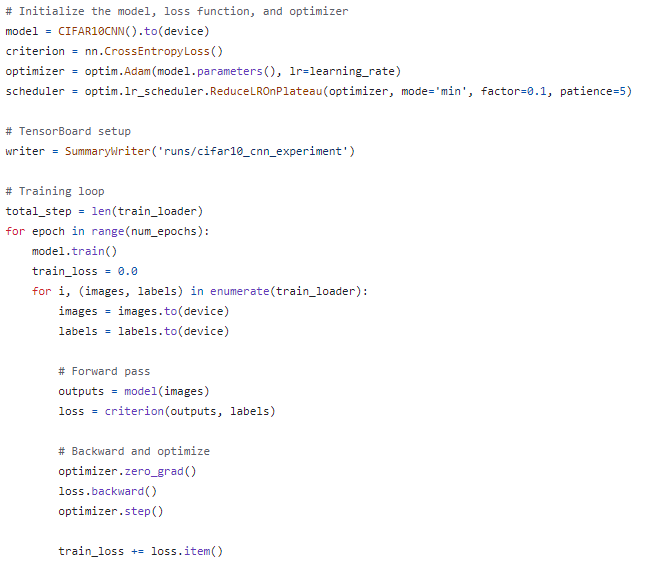

A few other details about the code:
- Manual switching between training and validation modes
- Manual specification of gradient computation
- Usage of the inferior `SummaryWriter` class for logging
- A learning rate scheduler (this one is fine)

Now, let's see how fares Pytorch Lightning.

## PyTorch Lightning Workflow

### Defining model architecture with `LightningModule` class

Defining model architecture in Lightning is almost the same as in pure PyTorch:

In [36]:
class CIFAR10CNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The only difference is that we subclass from the `LightningModule` class not `nn.Module` from PyTorch. 

`LightningModule` is an extension of the `nn.Module` class. It combines:
- training 
- validation
- testing 
- prediction 
- optimization 

steps of the PyTorch workflow into a single interface without any loops.  When you start using `LightningModule`, the PyTorch code isn't abstracted - just organized into six sections:
- Initialization (`__init__` and `setup` methods)
- Train loop (`training_step()` method)
- Validation loop (`validation_step()` method)
- Test loop (`test_step()`) method
- Prediction loop (`prediction_step()` method)
- Optimizers and LR schedulers (`configure_optimizers()`)

We've already seen the initialization part. Let's move on to the training step.

### Writing a training step

To activate a training loop, we override the `training_step()` method of our model class:

```python
# Add the method inside the class
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    self.log('train_loss', loss)
    return loss
```

This method collapses the entire training loop into a few lines of code. First, we extract the feature and target arrays from the current `batch`, which is provided by a data loader. Then, we run a forward pass `self(x)` and compute the loss. Then, we simply log the training loss using the built-in Lightning logger. 

You can log other metrics like training accuracy inside this method:

In [37]:
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(1) == y).float().mean()
    
    self.log("train_loss", loss)
    self.log("train_acc", acc)
    return loss, acc

The `log()` method automatically reduces the metrics calculation to the epoch level. It has additional parameters if you want custom logs:

```python
# Log the loss at each training step and epoch, create a progress bar
self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
```

In the end, you just have to remember to return the computed metrics. To learn more about the training step, visit [this page](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#training) of the Lightning AI docs.

### Writing validation and test steps

Validation and test steps are very similar to the training step:

In [38]:
def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)


def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (y_hat.argmax(1) == y).float().mean()
    self.log('test_loss', loss)
    self.log('test_acc', acc)

The only difference is that you don't return the computed metrics. Lightning automatically assigns the correct data loaders to validation and test steps and create the loops under the hood. 

Even though `validation_step` and `test_step` look the same, they have a key distinction:
- `validation_step` goes into action during training.
- `test_step` only does during testing, or in other words, when you call the `.test()` method of the trainer object. We will see an example soon.

See the [validation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#validation) and [testing](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#testing) sections of the documentation for more details.

### Configuring optimization and LR schedulers

To set the optimizer and a learning rate scheduler, we need to override the `configure_optimizers()` method of our class:

In [39]:
def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
        },
    }

Above, we define an `Adam` optimizer, passing in the hyperparameters and the learning rate. We also define a `ReduceLROnPlateau` scheduler to reduce the learning rate when validation loss plateaus. 

Both of these objects must be returned in one of the following ways:

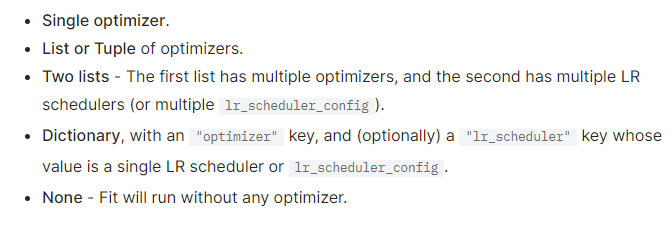

Returning a dictionary of objects is the most flexible as it allows defining schedulers that require extra arguments. For more details, refer to [this section](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#configure-optimizers) of the documentation.

### Defining callbacks

### Creating a `Trainer` class in PyTorch Lightning

### Running and testing the model

## DataModule: Streamlining Data Handling
    A. Creating a custom DataModule
    B. Implementing train_dataloader, val_dataloader, and test_dataloader



## Advanced Features
    A. Callbacks
    B. Logging and visualization
    C. Multi-GPU training
    D. Gradient accumulation
    E. Mixed precision training



## Best Practices and Tips
     A. Debugging strategies
     B. Performance optimization
     C. Code organization



## Conclusion and Further Resources